# **Minimum Viable Product**

This notebook contains the modelling for the mininum viable product for Case Studies in Data Science COSC2669/COSC2186. The data set used is the FICO dataset which has been cleaned and processed for modelling. The data cleaning process can be viewed at [Data cleaning](https://github.com/WorkstationChris/WIL_Project/blob/main/Resources/minimal_dataset_notebook.ipynb)

Initial modelling and outlier detection can be viewed here [Initial Modelling](https://github.com/WorkstationChris/WIL_Project/blob/main/Resources/binary_classification.ipynb).

This notebook which will be creating the minimum viable product for the project.



### **Objectives for MVP**
1. Inspect target distribution and feature types
2. Determine an evaluation metric
3. Determine a good baseline Model
4. Refine and develop from baseline model to the final Model - "Minimum Viable Product"



In [4]:
# Mount to Google Drive (This step only required if using google colab)
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/case_study/Resources/* .

ModuleNotFoundError: No module named 'google.colab'

In [5]:
# Import Libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import shap

# **Data**

Using the scaled data for modelling. We can swtich with the normalised data set to see how the results vary depending on the dataset. A important insights obtained from data cleaning is the distribution of variables and the analysis of these variables. The primary data variable will be a data frame consisting of all predictiors and the target variable will be the labels we want to predict.



In [6]:
# Read cleaned data
data = pd.read_csv("scaled.csv", index_col= 0)
# data = pd.read_csv("normalised.csv", index_col= 0)

target = pd.read_csv("target.csv", index_col= 0)
data.head(10)

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,...,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,RecentDelq_1yr,RecentDeql_2yr,RecentInquiry_1yr_excl7days,RcentInquiry_2yr_excl7days
0,0.360656,0.177278,0.017621,0.251572,0.253165,0.157895,0.000000,0.83,0.4,0.4,...,0.142241,0.157113,0.25000,0.290323,0.055556,0.69,1.0,1.0,0.0,0.0
1,0.459016,0.069913,0.066079,0.116352,0.025316,0.210526,0.210526,1.00,1.0,0.0,...,0.000000,0.157113,0.00000,0.000000,0.055556,0.00,0.0,0.0,0.0,0.0
2,0.557377,0.079900,0.022026,0.062893,0.113924,0.000000,0.000000,1.00,0.0,0.0,...,0.228448,0.140127,0.12500,0.322581,0.055556,0.86,0.0,0.0,0.0,0.0
3,0.540984,0.208489,0.004405,0.216981,0.354430,0.052632,0.052632,0.93,0.0,0.2,...,0.310345,0.176221,0.18750,0.387097,0.166667,0.91,0.0,0.0,0.0,0.0
4,0.786885,0.413233,0.118943,0.402516,0.151899,0.000000,0.000000,1.00,0.0,0.0,...,0.219828,0.188960,0.09375,0.290323,0.000000,0.80,0.0,0.0,0.0,0.0
5,0.426230,0.168539,0.048458,0.232704,0.392405,0.000000,0.000000,0.91,0.2,0.2,...,0.267241,0.197452,0.37500,0.387097,0.166667,0.94,1.0,1.0,0.0,0.0
6,0.344262,0.107366,0.030837,0.103774,0.316456,0.000000,0.000000,0.92,0.2,0.2,...,0.383621,0.161359,0.21875,0.483871,0.111111,1.00,1.0,1.0,0.0,0.0
7,0.573770,0.182272,0.030837,0.191824,0.215190,0.000000,0.000000,0.83,0.0,0.2,...,0.120690,0.101911,0.06250,0.322581,0.111111,0.40,0.0,0.0,0.0,0.0
8,0.426230,0.401998,0.008811,0.421384,0.303797,0.000000,0.000000,0.85,0.2,0.2,...,0.293103,0.157113,0.21875,0.290323,0.166667,0.90,1.0,1.0,0.0,0.0
9,0.459016,0.096130,0.017621,0.100629,0.240506,0.000000,0.000000,0.95,0.2,0.2,...,0.133621,0.182590,0.15625,0.354839,0.055556,0.62,1.0,1.0,0.0,0.0


### **One-Hot Encoding**

From the data cleaning we know that 'MaxDelqEver' & 'MaxDelq2PublicRecLast12M' are non-binary categorical variables. So it might be useful to one-hot encode them before modelling to ensure that the model can make sense of the data it is being fed.

Another key reason is though this is the first iteration of the model. Future iterations will need to encorporate a method to be transparent in its output, so having individual these two non- binary variables broken down into presence and absence construct will add to the explainability

In [7]:
# One hot Encoding
fico_df = pd.get_dummies(data, columns=['MaxDelqEver','MaxDelq2PublicRecLast12M'])
# fico_df.head()

### **Target distribution**

The target variables distribution will give us insights on how to choose different parameters of our model. It is also necessary to determine a good evaluation meteric and any necessary weights that might need to be added.

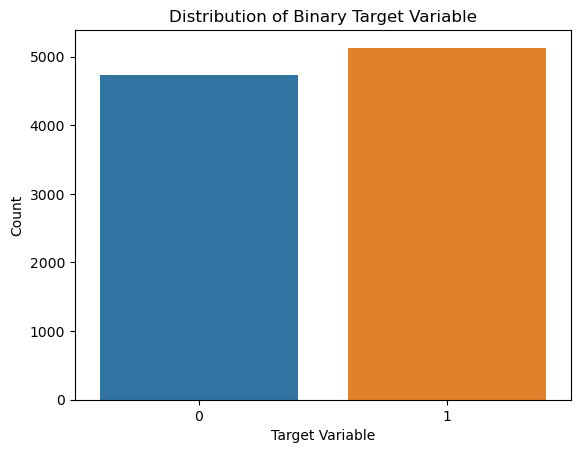

In [8]:
# Create a countplot
sns.countplot(data=target, x='RiskPerformance')

# Add labels and title
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.title('Distribution of Binary Target Variable')

# Show the plot
plt.show()

### **Training, Validation and Testing Split**

In [9]:
# adjust train, test, validation size as you wish
X_train, X_temp, y_train, y_temp = train_test_split(fico_df, target, test_size=0.30, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.35, random_state=42)

print("\nX_train shape:", X_train.shape)
print("X_validation shape:", X_validation.shape)
print("X_test shape:", X_test.shape, "\n")

print("y_train shape:", y_train.shape)
print("y_validation shape:", y_validation.shape)
print("y_test shape:", y_test.shape)


X_train shape: (6902, 35)
X_validation shape: (1923, 35)
X_test shape: (1036, 35) 

y_train shape: (6902, 1)
y_validation shape: (1923, 1)
y_test shape: (1036, 1)


### **Inference**

It is clear from the plot there is no heavy class imbalance and with the availablity of quite a reasonably large data set, the model will have enough data to pick up on both presence and absence of the target variable.



### **Plotting Function**

We will need a plotter function to analyse the performance of our model i.e. the loss and accuracy curves. This function is defined as follows:

In [10]:
def plotter(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Plot training and validation loss
    ax1.plot(epochs, train_loss, 'b', label='Training Loss')
    ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot training and validation accuracy
    ax2.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# **Baseline Model**

A baseline model provides a benchmark for evaluating the performance of more complex models. It gives you a starting point to assess whether your advanced models are improving upon a simple, naive approach.

Also this can provide insights into feature importance. You can use the baseline results to identify which features are informative and which may be less relevant, helping us prioritize feature engineering efforts.

Initial efforts to determine a good representative model and model selection can be viewed in [Model Experimentation](https://github.com/WorkstationChris/WIL_Project/blob/main/Resources/binary_classification.ipynb)

Another important factor to keep in mind is to not deliberately undercut the baseline model.

### **Loss Metric**

The loss metric used for this task is Binary Cross-Entropy. Binary Cross-Entropy, also known as log loss or logistic loss, is a common loss function used in binary classification problems. It is a fundamental and widely used loss metric for models that output probability scores for binary classification tasks.

The binary cross-entropy loss is calculated using the following formula for a single data point:

$$
L(y,\hat {y}) = - (y \log ({\hat y}) + (1 - y) \log(1-{\hat y}))
$$



### **Evaluation metric**

A few important considerations while determining the evaluation metric is analysing class imbalance and misclassification cost between class. In our particular case we do not have heavy class imbalance and as mentioned earlier the size of the dataset is reasonably large.

Based on these considerations the evaluation metric used is accuracy.

In [11]:
baseline_model = Sequential()

# Add input layer
baseline_model.add(Dense(64, activation = 'relu', input_dim = X_train.shape[1]))

# Hidden layer 1
baseline_model.add(Dense(32, activation = 'relu'))
baseline_model.add(Dropout(0.6))  # Dropout layer to reduce overfitting

# Output layer with sigmoid function
baseline_model.add(Dense(units=1, activation = 'sigmoid'))

# Compile with loss function, optimizer, and evaluation metric
baseline_model.compile(optimizer=Adam(learning_rate=0.0006),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Early Stopping for validation loss
# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train model
baseline_history = baseline_model.fit(X_train, y_train,
                                      validation_data=(X_validation, y_validation),
                                      epochs=100,
                                      # callbacks=[early_stopping],
                                      batch_size=16,
                                      verbose = 0)

# Evaluate the model on the test data
loss, accuracy = baseline_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

2023-09-19 16:16:39.589389: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


33/33 [==============================] - 0s 427us/step - loss: 0.5616 - accuracy: 0.7220
Test Loss: 0.5616
Test Accuracy: 0.7220


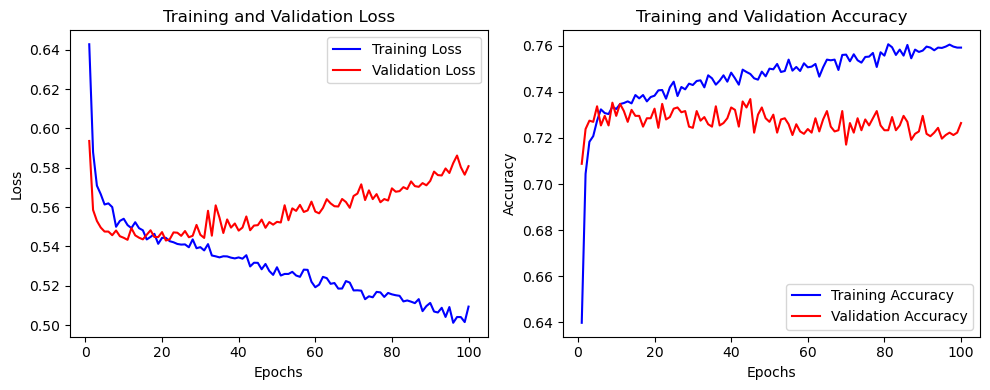

In [12]:
plotter(baseline_history)

# **Minimum Viable Product**

Based on the baseline model we can develop a minimum viable product by trying to reduce the overfitting in the baseline. The reason to try to mitigate this is to ensure our model can generalize better in new cases. To reduce overfitting we can either add regularization or reduce the complexity of our model or implement a combination of both which does not affect the accuracy while not increasing the validation loss.

It might also be helpful to experiment with different smaller learning rates.

In [13]:
mvp_model = Sequential()

# Add input layer
mvp_model.add(Dense(64, activation = 'relu', input_dim = X_train.shape[1]))

# Hidden layer 1
mvp_model.add(Dense(32, activation = 'relu'))
mvp_model.add(Dropout(0.45))  # Dropout layer to reduce overfitting

# Output layer with sigmoid function
mvp_model.add(Dense(units=1, activation = 'sigmoid'))

# Compile with loss function, optimizer, and evaluation metric
mvp_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Early Stopping for validation loss
# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train model
mvp_history = mvp_model.fit(X_train, y_train,
                            validation_data=(X_validation, y_validation),
                            epochs=70,
                            # callbacks=[early_stopping],
                            batch_size=16,
                            verbose = 0)

# Evaluate the model on the test data
mvp_loss, mvp_accuracy = mvp_model.evaluate(X_test, y_test)
print(f"Test Loss: {mvp_loss:.4f}")
print(f"Test Accuracy: {mvp_accuracy:.4f}")


33/33 [==============================] - 0s 486us/step - loss: 0.5370 - accuracy: 0.7259
Test Loss: 0.5370
Test Accuracy: 0.7259


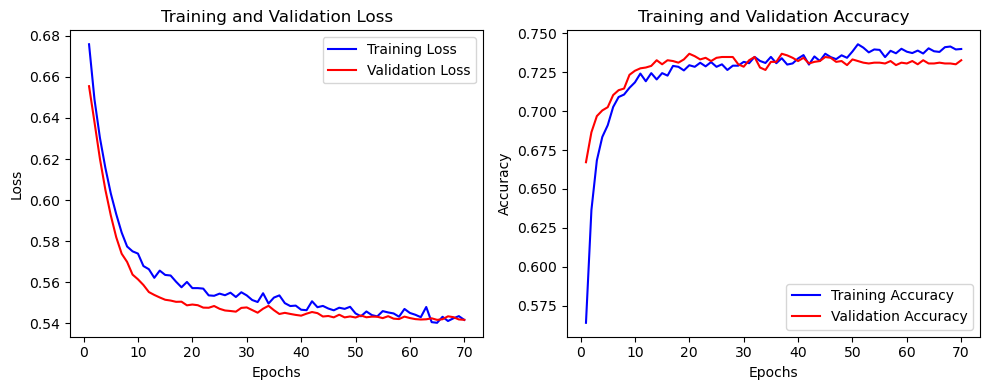

In [14]:
plotter(mvp_history)

# **Results**

We thus have a minimum viable model. In terms of loss and accuracy, the model achieves the same standards as the model developed by the winners of the [FICO Recognition awards](https://community.fico.com/s/blog-post/a5Q2E0000001czyUAA/fico1670). The final model does not show any signs of over fitting or under fitting which goes to say the model has good generalization ability.

## **Saved Model for Web Application**

In [15]:
# mvp_model.save('Risk_Prediction_Model.h5')

# **Final Product**

Now that we have a model that can predict the risk associated with an applicant, we can now use this model to deploy the product. This stage of the deployment process will include the prediction function, the actual prediction (as a sample we will be using random samples from the test set for testing puposes) and finally a plot to visualise the confidence level of an applicants capability to successfully repay a loan.

## **Prediction**

To predict new cases we are using samples from the test set to predict the risk scores of users. For testing purposes we have created a random generator.

In [16]:
def predict_loan_risk(model, input_data):

    # Make predictions
    predictions = model.predict(input_data)

    # Create a pandas Series for the predicted probabilities
    predicted_probabilities = pd.Series(predictions.squeeze())

    return predicted_probabilities


In [17]:
# Get the number of samples in your test set
num_test_samples = X_test.shape[0]

# Choose a random index from the test set
random_index = random.randint(0, num_test_samples - 1)

# Extract the random test observation
random_test_observation = X_test.iloc[random_index]

# Reshape the observation to match the model's input shape
random_test_observation = random_test_observation.values.reshape(1, -1)  # Reshape to a 2D array

# Use the predict function with the random test observation
predicted_probabilities = predict_loan_risk(mvp_model, random_test_observation)
predicted_probabilities = float(predicted_probabilities)
predicted_probabilities = round(predicted_probabilities ,2)

# Chance of repayment
repayment_probability = (1 - predicted_probabilities) * 100
repayment_probability = round(repayment_probability ,2)
# Define the threshold
threshold = 0.5

# Make a binary prediction based on the threshold
if predicted_probabilities >= threshold:
    prediction = "Risk"
else:
    prediction = "Non-Risk"

# Display the random test observation, its predicted probability, and the binary prediction
print("Random Test Observation:")
print(random_test_observation)
print("\nPredicted Probability:")
print(f"{predicted_probabilities}")

print(f"\nChance of successful repayment:")
print(f"{repayment_probability}%")

print("\nPrediction:")
print(prediction)

1/1 [==============================] - 0s 51ms/step
Random Test Observation:
[[0.81967213 0.57677903 0.05286344 0.46855346 0.20253165 0.
  0.         0.94       0.15384615 0.         0.19       0.01515152
  0.01515152 0.07758621 0.05732484 0.0625     0.29032258 0.
  0.75       0.         1.         0.         0.         0.
  1.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.        ]]

Predicted Probability:
0.2

Chance of successful repayment:
80.0%

Prediction:
Non-Risk


## **Confidence Plot**

We have will be using the value on the sigmoid curve as a measure of confidence the model has for the successful repayment of the loan. This measure allows the user to gain insights into where they lie in terms of capability of repayment which allows them to take an informed decision.

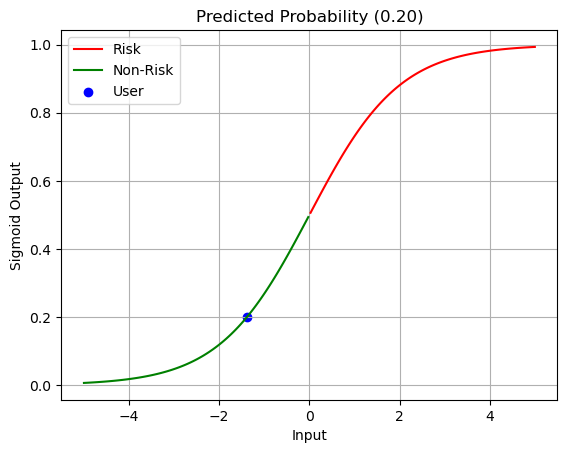

In [18]:
# Predicted probability for the test observation
predicted_probability = predicted_probabilities

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Generate x values (a range of values from -7 to 7)
x = np.linspace(-5, 5, 200)

# Calculate the corresponding y values using the sigmoid function
y = sigmoid(x)

# Plot the sigmoid curve above 0.5 on the y-axis in red and below 0.5 in green
plt.plot(x[y >= 0.5], y[y >= 0.5], color='red', label='Risk')
plt.plot(x[y <= 0.5], y[y <= 0.5], color='green', label='Non-Risk')

# Calculate the x-coordinate on the sigmoid curve for the given y-coordinate (predicted_probability)
x_predicted = np.interp(predicted_probability, y, x)

# Highlight the predicted probability point
plt.scatter(x=[x_predicted], y=predicted_probability, color='blue', label='User')

# Label the axes and add a legend
plt.xlabel('Input')
plt.ylabel('Sigmoid Output')
plt.legend()

# Show the plot
plt.title(f'Predicted Probability ({predicted_probability:.2f})')
plt.grid(True)
plt.show()


# **Feature Importance**

To reduce runtime of calculating shap values, we used Kmeans sampling method in shap. To choose the number of clusters for sampling, we first used the elbow method, choosing 8 as a good value. Then using a summary_plot, we plotted the most important features in order.

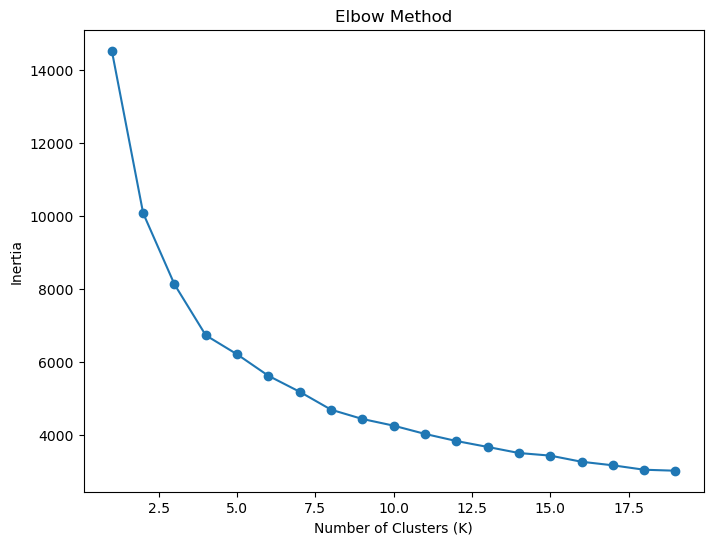

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(1, 20)  # Try different values of K
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [33]:
K = 8
centers = shap.kmeans(X_train, K)
e = shap.KernelExplainer(mvp_model, centers)
shap_values = e.shap_values(X_test)
shap.initjs()
# visualize the first prediction's explanation with a force plot
shap.force_plot(e.expected_value[0], shap_values[0][0])


  0%|          | 0/1036 [00:00<?, ?it/s]

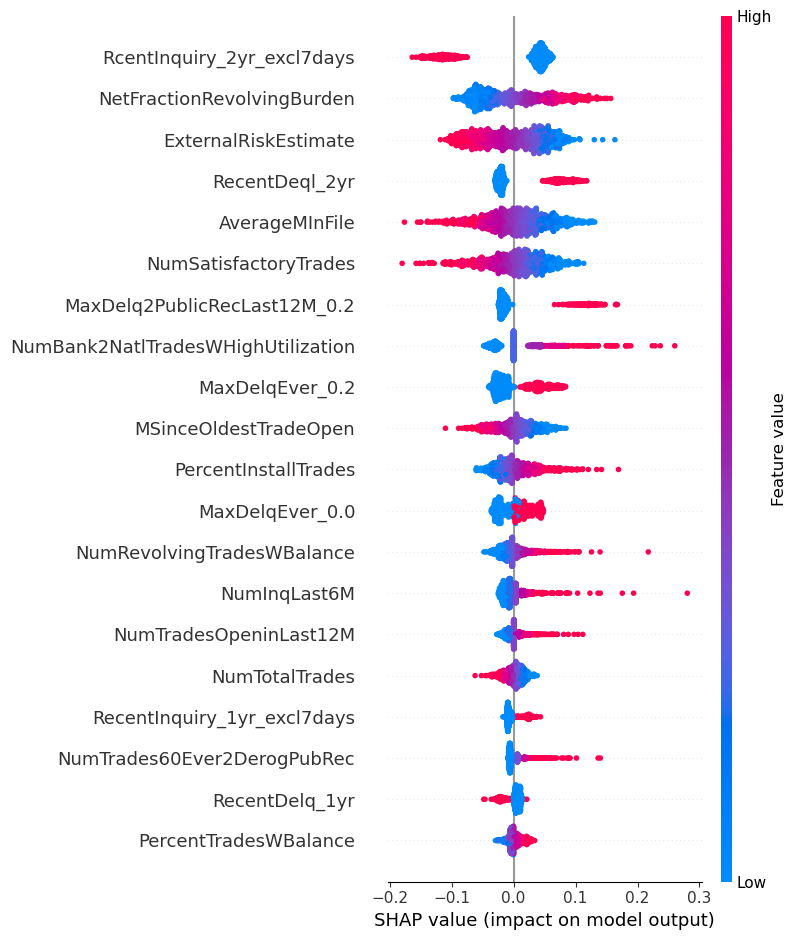

In [34]:
shap.summary_plot(shap_values[0], X_test)

# **Conclusion**

We now have a Minimum Viable Product which can which uses a Multi layer perceptron model to classify users based on the risk associated with the respective customer.


The next step would be to use the developed model in a meb page which can be readily used to get predictions.

**Future Development:**

For this iteration the model acts like a black box, so for the iterations of development we will need to prioritise the explainability of our model.

Feature engineering and efforts towars Multi-Output Neural network can help us introduce transparency to our model.